In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def linear( x, m, b ):
    return m * x + b

In [5]:
calib1 = pd.read_csv('/Users/eframe/repos/dmi/data/calibfiles/calibration2.csv', header=None).T # cpm
calib2 = pd.read_csv('/Users/eframe/repos/dmi/data/calibfiles/HidexAMG-225Ac-standard.csv', header=None).T * 2 # cpm
calib3 = pd.read_csv('/Users/eframe/repos/dmi/data/calibfiles/calibration.csv', header=None).T # cpm
energy = np.arange(2048)

In [6]:
# Calibration
activity1 = np.repeat([1.8, 0.6, 0.3], 2)
activity2 = np.repeat( [ 1, 0.5, 0.2, 0.1, 0.04, 0.008 ], 3 ) 
activity3 = np.repeat( [ 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.007813, 0.003906, 0.001953 ], 3 ) 

In [7]:
emask218 = ( energy > 175 ) & ( energy < 250 )
bmask218 = ( ( energy < 175 ) & ( energy > 175 - 37.5 ) ) | ( ( energy > 250 ) & ( energy < 250 + 37.5 ) )
emask440 = ( energy > 385 ) & ( energy < 490 )
bmask440 = ( ( energy < 385 ) & ( energy > 385 - 52.5 ) ) | ( ( energy > 490 ) & ( energy < 490 + 52.5 ) )

In [8]:
activity = activity3.copy()
calib = calib3.copy()
data_matrix = np.zeros( ( activity.shape[0], 2 ) )
for i in np.arange( len( activity ) ):
    spectra = calib[i]
    fr_net = np.sum( spectra[emask218] ) - np.sum( spectra[bmask218] )
    bi_net = np.sum( spectra[emask440] ) - np.sum( spectra[bmask440] )
    data_matrix[i,0] = fr_net  # cpm
    data_matrix[i,1] = bi_net  # cpm --> 30 second measurement converted to minute measurement
#     print(activity[i], fr_net, bi_net)

In [9]:
cts_theory = activity * 37000 # uCi --> Bq 
fr_theory = cts_theory * 0.116
bi_theory = cts_theory * 0.261

fr_eff = ( data_matrix[:,0] ) / 60 / fr_theory
bi_eff = ( data_matrix[:,1] ) / 60 / bi_theory

det_eff = np.array( [ np.mean( fr_eff ), np.mean( bi_eff ) ] )
det_eff

array([0.46443377, 0.22746328])

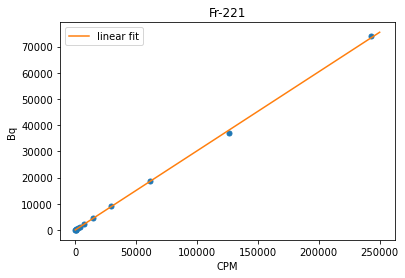

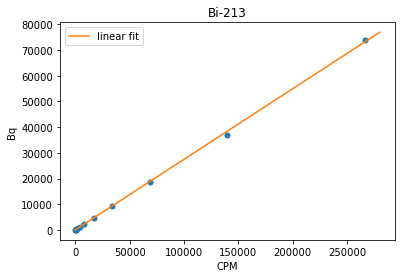

In [10]:
# Linear Calibration Between CPS and Bq
i1, n1 = 2, 3
i2, n2 = 3, 6
i3, n3 = 3, 11
i, n = i3, n3
fr_cpm = np.insert( np.mean( data_matrix[:,0].reshape(-1, i), axis=1 ), n, 0 ) 
bi_cpm = np.insert( np.mean( data_matrix[:,1].reshape(-1, i), axis=1 ), n, 0 ) 
Bq = np.insert( np.mean(activity.reshape(-1, i), axis=1 ), n, 0 ) * 37000 

popt_fr, pcov_fr = curve_fit( linear, fr_cpm, Bq, bounds=( [-np.inf, 0], [np.inf, np.inf] ) )
popt_bi, pcov_bo = curve_fit( linear, bi_cpm, Bq, bounds=( [-np.inf, 0], [np.inf, np.inf] ) )

p_fr = np.poly1d( popt_fr ) 
p_bi = np.poly1d( popt_bi )

%matplotlib inline
plt.plot( fr_cpm, Bq, '.', markersize=10 )
plt.plot( np.arange( 0, 250000 ), p_fr( np.arange( 0, 250000 ) ), label='linear fit' )
plt.ylabel('Bq')
plt.xlabel('CPM')
plt.title('Fr-221')
plt.legend()
plt.show()

%matplotlib inline
plt.plot( bi_cpm, Bq, '.', markersize=10 )
plt.plot( np.arange( 0, 280000 ), p_bi( np.arange( 0, 280000 ) ), label='linear fit' )
plt.ylabel('Bq')
plt.xlabel('CPM')
plt.title('Bi-213')
plt.legend()
plt.show()

In [12]:
biod1 = pd.read_csv('/Users/eframe/repos/dmi/data/biod1.csv', header=None).T
biod1 = biod1.rename( columns = {0:'tumor', 1:'liver', 2:'kidney', 3:'heart', 4:'muscle', 
              5:'bone', 6:'spleen', 7:'pancreas',8:'lungs', 9:'test'} ).drop( columns=['test'] )[1:]
biod2 = pd.read_csv('/Users/eframe/repos/dmi/data/biod2.csv', header=None).T
biod2 = biod2.rename( columns = {0:'tumor', 1:'spleen', 2:'muscle', 3:'bone', 4:'kidney', 
              5:'liver', 6:'test', 7:'pancreas',8:'heart', 9:'lungs'} ).drop( columns=['test'] )[1:]
w1 = np.array( [ 0.2997, 0.5970, 0.3271, 0.2519, 0.1281, 0.0862, 0.0360, 0.0772, 0.1744 ] )
w2 = np.array( [ 0.1856, 0.0525, 0.1465, 0.0440, 0.4229, 0.7307, 0.0398, 0.1527, 0.1986 ] )
energy = biod1.index.values

In [13]:
# Decay Correction
time1 = 9 # day separation between coded aperture measurement and biodistribution analysis
time2 = 11 # day separation between coded aperture measurement and biodistribution analysis
lam = np.log(2) / 10
decay_corr1 = np.exp( -lam * time1 )
decay_corr2 = np.exp( -lam * time2 )

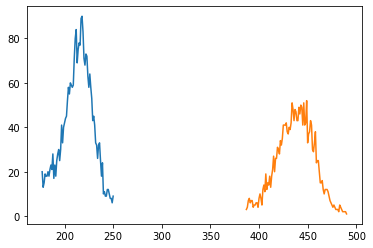

tumor [%ID/g]: 1152.4984 (Fr221) 1063.9526 (Bi213)



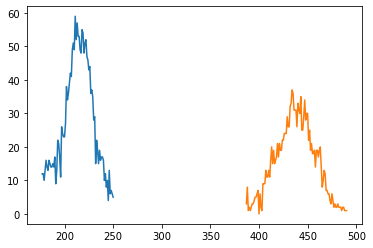

liver [%ID/g]: 786.1786 (Fr221) 706.0543 (Bi213)



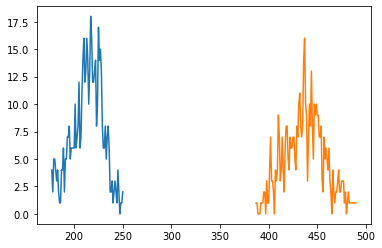

kidney [%ID/g]: 191.6134 (Fr221) 210.2268 (Bi213)



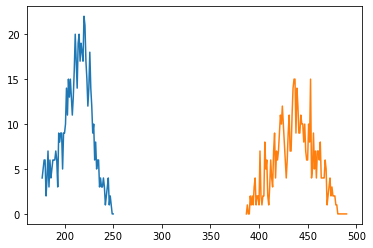

heart [%ID/g]: 246.2796 (Fr221) 238.9407 (Bi213)



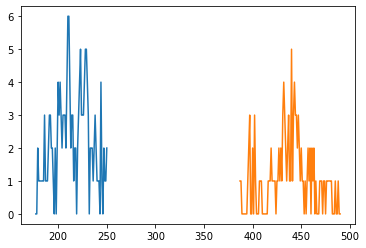

muscle [%ID/g]: 60.3019 (Fr221) 42.5581 (Bi213)



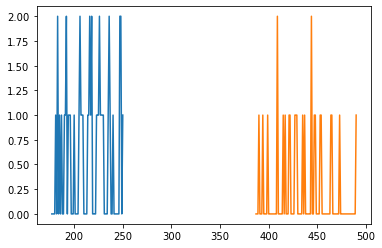

bone [%ID/g]: 7.8900 (Fr221) -1.0255 (Bi213)



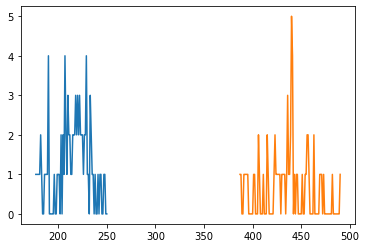

spleen [%ID/g]: 24.2335 (Fr221) 16.9207 (Bi213)



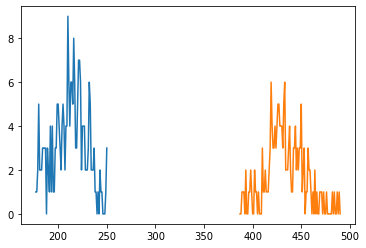

pancreas [%ID/g]: 91.2982 (Fr221) 67.1700 (Bi213)



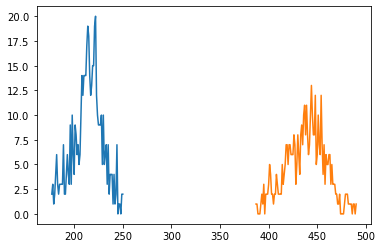

lungs [%ID/g]: 176.3971 (Fr221) 194.8443 (Bi213)



In [23]:
%matplotlib inline
IG = 20 * 1000 # Bq
biod = biod1.copy()
w = w1.copy()
decay_corr = decay_corr1.copy()
col = biod.columns.values
for i in np.arange( biod.shape[1] ):
    data = biod[col[i]].values
    c218 = ( np.sum( data[emask218] ) - np.sum( data[bmask218] ) ) / decay_corr # cpm
    c440 = ( np.sum( data[emask440] ) - np.sum( data[bmask440] ) ) / decay_corr # cpm
    plt.plot( energy[emask218], data[emask218] )
    plt.plot( energy[emask440], data[emask440] )
    plt.show()
#     print( col[i], '[cpm]:', "%.0f" % c218, '(Fr221)', "%.0f" % c440,  '(Bi213)' )
    a = p_fr(c218)/IG * 100 / w[i]
    b = p_bi(c440)/IG * 100 / w[i]
    a = p_fr(c218) 
    b = p_bi(c440) 
    print( col[i], '[%ID/g]:', "%.4f" %a, '(Fr221)', "%.4f" %b, '(Bi213)' )
    print('')

In [18]:
w = 0.597+0.252+0.174
c_fr = 786+246
c_bi = 238+71+125
a = c_fr/IG * 100 / w
b = c_bi/IG * 100 / w
print(a,b)

2.017543859649123 2.0036934441366574


In [20]:
print(c_fr, c_bi)

437 434


In [3]:
lam = np.log(2) / 10
decay_corr = np.exp( -lam * 2 )